In [1]:
import json
import matplotlib.pyplot as plt
import os

import numpy as np
from pandas import read_csv, merge, concat
from skimage.io import imread
from cv2 import resize

from keras import backend as K
from keras.optimizers import Adam
from segmentation_models import losses
from keras.models import load_model

from efficientnet.keras import EfficientNetB0
from efficientnet.keras import preprocess_input

BATCH_SIZE = 1
IMG_SIZE = 384
LEARNING_RATE = 0.00001
ALPHA = 10.0


PATH_CHECKPOINT = 'models'
MODEL = 'efficientunet_256_1580639531_384_1580712972.hdf5'


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
binary_focal_loss = losses.BinaryFocalLoss(alpha=ALPHA)
dice_loss = losses.DiceLoss(smooth=1)


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def binary_focal_dice_loss(y_true, y_pred):
    return binary_focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)


In [3]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    _img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        _img[lo:hi] = 1
    return _img.reshape(shape).T


def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype=np.int16)
    for _mask in in_mask_list:
        if isinstance(_mask, str):
            all_masks += rle_decode(_mask)
    return all_masks


def make_image_generator(in_df, batch_size):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            _img = imread(rgb_path)
            _img = resize(_img, (IMG_SIZE, IMG_SIZE))

            masks_as_img = masks_as_image(c_masks['EncodedPixels'].values)
            _mask = resize(masks_as_img, (IMG_SIZE, IMG_SIZE))
            _mask = np.expand_dims(_mask, -1)

            _img = _img.astype(np.float32)
            _mask = _mask.astype(np.uint8)

            out_rgb += [_img]
            out_mask += [_mask]
            if len(out_rgb) >= batch_size:               
                yield np.stack(out_rgb, 0), np.stack(out_mask, 0), c_img_id
                out_rgb, out_mask = [], []


In [4]:
def preprocess_data(_train_image_dir, _exclude_list, n_train=0.8, balanced=False):
    masks = read_csv(os.path.join(data_dir, 'train_ship_segmentations_v2.csv.zip'))

    masks = masks[~masks['ImageId'].isin(_exclude_list)]

    masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)
    unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()

    unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)

    n_train_split = int(n_train * len(unique_img_ids))

    train_ids = unique_img_ids.iloc[:n_train_split]
    valid_ids = unique_img_ids.iloc[n_train_split:]

    if balanced:
        ones = train_ids.loc[train_ids['has_ship'] == 1]
        zeros = train_ids.loc[train_ids['has_ship'] == 0]
        zeros = zeros.sample(len(ones))
        train_ids = concat([ones, zeros])

    masks.drop(['ships'], axis=1, inplace=True)

    _train_df = merge(masks, train_ids)
    _valid_df = merge(masks, valid_ids)

    return _train_df, _valid_df


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()


In [5]:
exclude_list = ['6384c3e78.jpg', '13703f040.jpg', '14715c06d.jpg', '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg',
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg', '66049e4ea.jpg']  # corrupted images

with open('config.json', 'r') as file:
    configs = json.load(file)

data_dir = configs["DATA_DIRECTORY"]
train_image_dir = os.path.join(data_dir, 'train_v2')

train_df, valid_df = preprocess_data(train_image_dir, exclude_list)

K.set_image_data_format('channels_last')

model = load_model(f'{PATH_CHECKPOINT}/{MODEL}', compile=False)

model.compile(
    optimizer=Adam(lr=LEARNING_RATE),
    loss=binary_focal_dice_loss,
    metrics=[dice_coef]
)



In [6]:
inference_generator_train = make_image_generator(train_df, BATCH_SIZE)

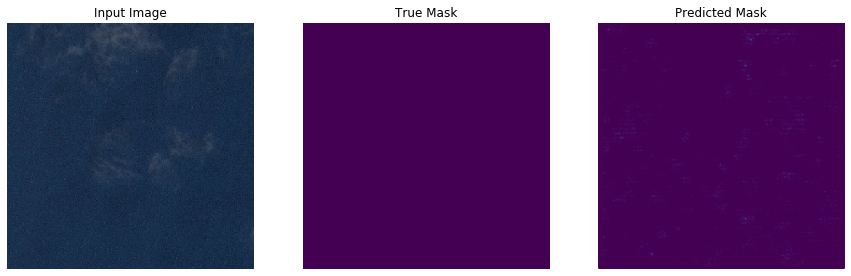

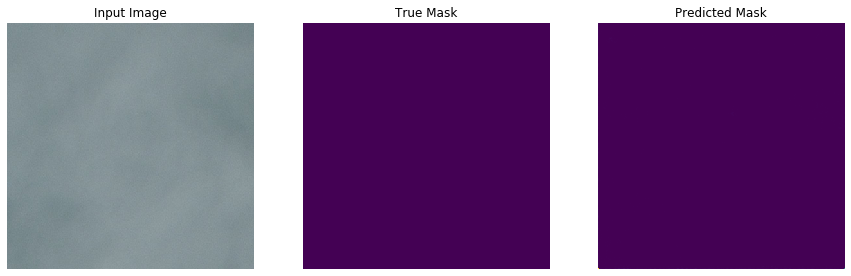

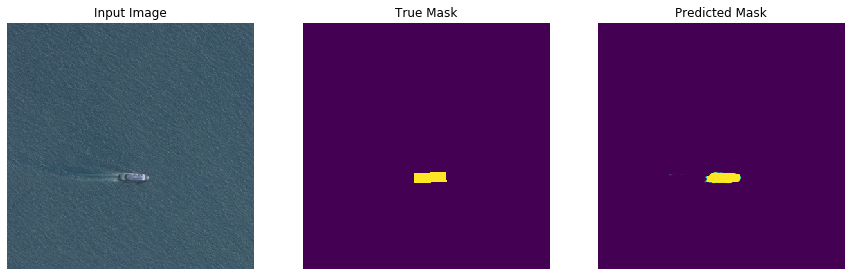

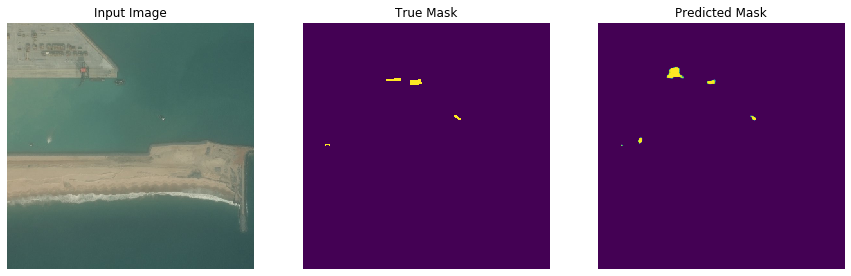

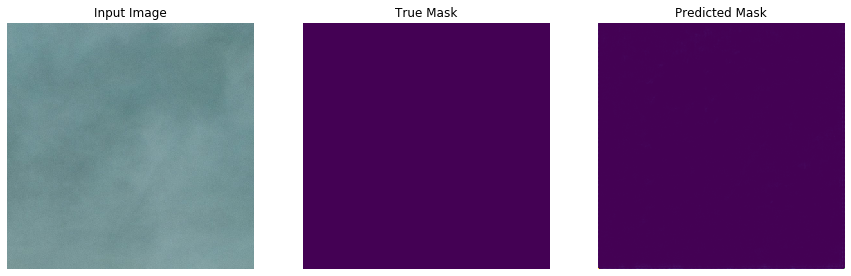

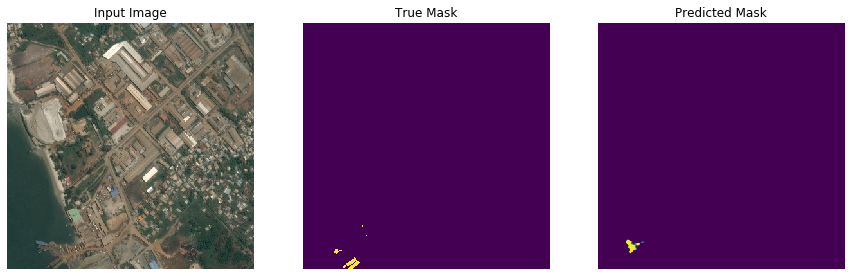

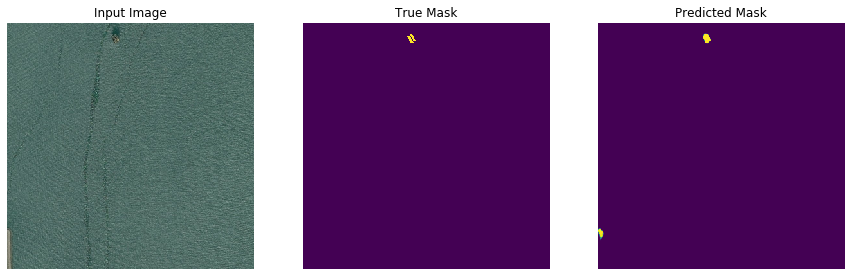

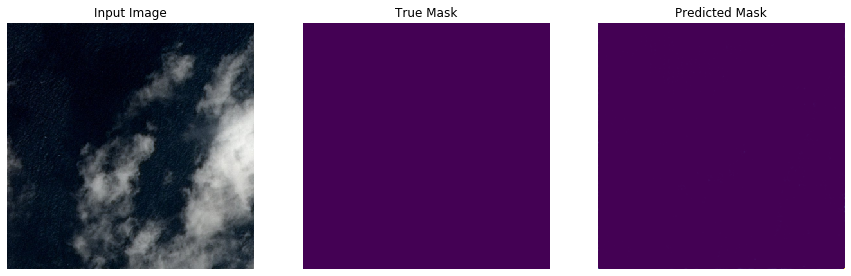

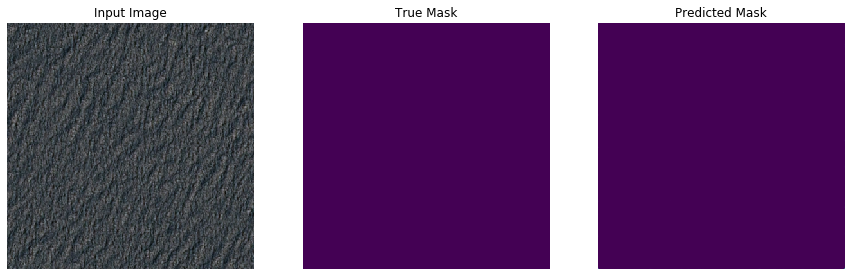

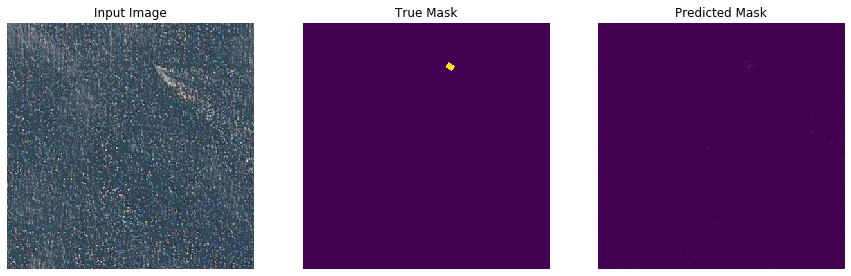

In [7]:
limit = 10
counter = 1

for img, mask, img_id in inference_generator_train:
    if counter > limit:
        break
    mask_pred = model.predict(preprocess_input(img.copy()))

    display([img[0] / 255., mask[0, :, :, 0], mask_pred[0, :, :, 0]])

    counter += 1


In [8]:
inference_generator_valid = make_image_generator(valid_df, BATCH_SIZE)

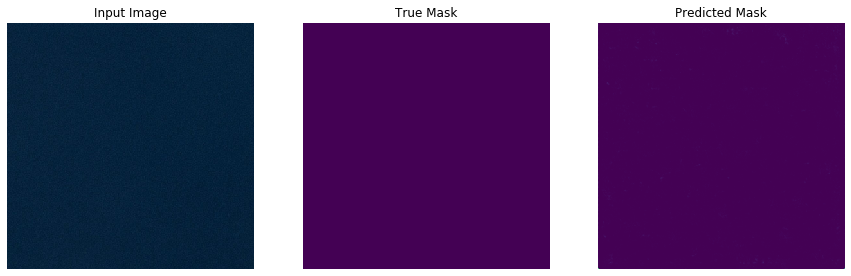

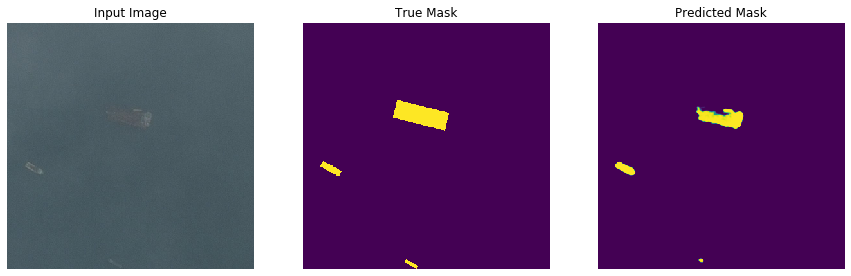

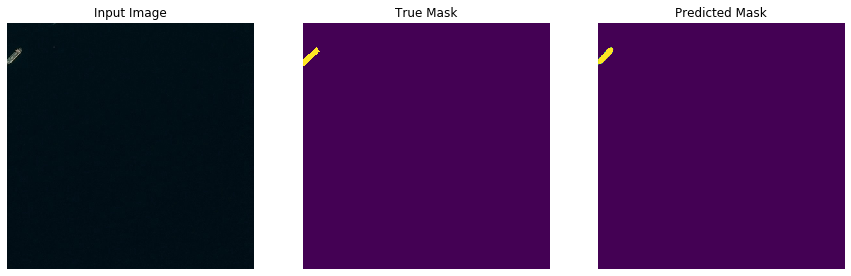

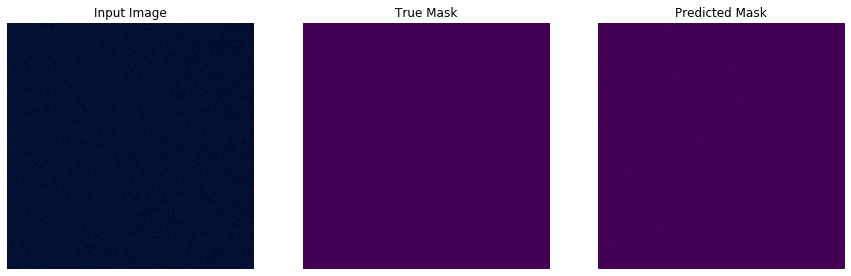

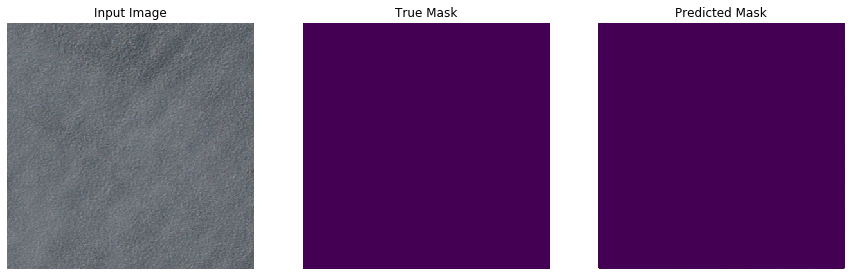

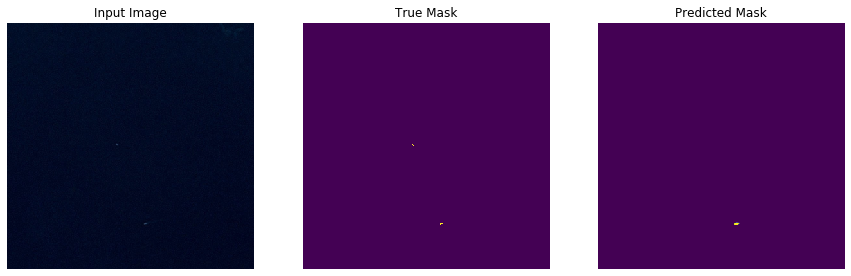

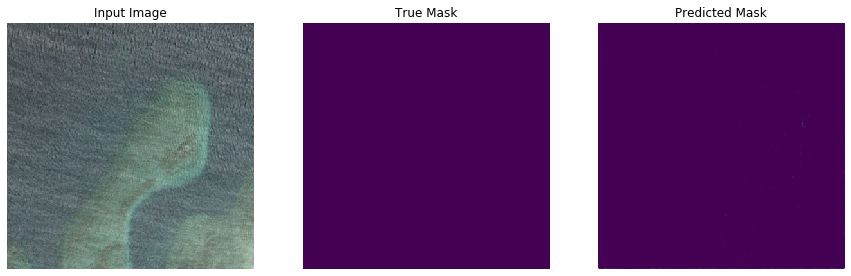

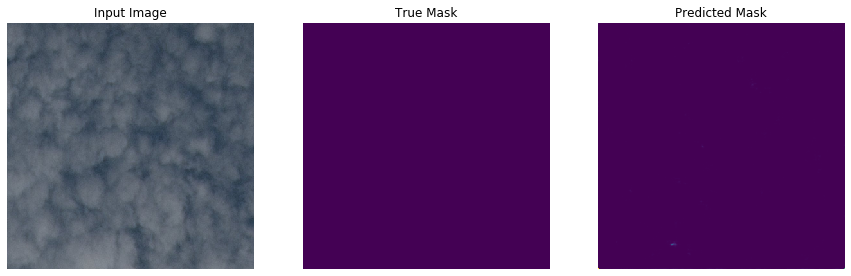

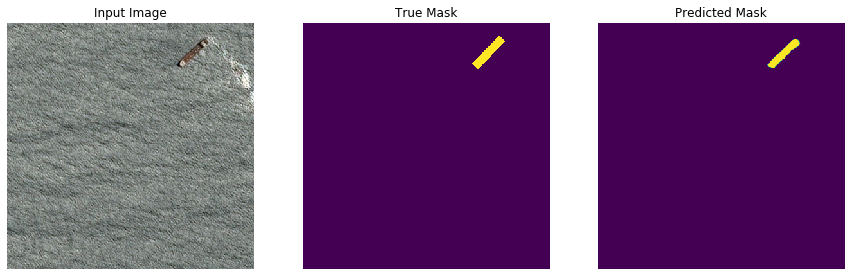

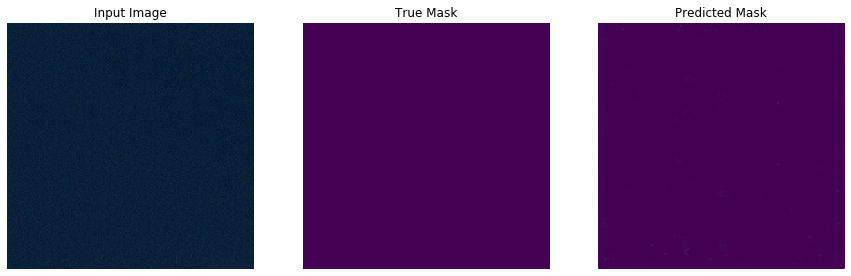

In [11]:
limit = 10
counter = 1

for img, mask, img_id in inference_generator_valid:
    if counter > limit:
        break
    mask_pred = model.predict(preprocess_input(img.copy()))

    display([img[0] / 255., mask[0, :, :, 0], mask_pred[0, :, :, 0]])

    counter += 1
